In [18]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy

import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf

print('done')


ND...
key='ND' lf.shape=(534, 6) (0, 31053)
HFD8...
key='HFD8' lf.shape=(2909, 6) (2902, 31053)
HFD14...
key='HFD14' lf.shape=(4903, 6) (4893, 31053)
done


In [3]:
# merge all expression
rdf = []
for key in keys:
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rdf.append(rf)

rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf.head()

rdf.shape=(7795, 31053)


Unnamed: 0,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
cellId,,,,,,,,,,,,,,,,,,,,,
AAACCCACACAAAGCG.1_HFD8,0,0,0,0,0,0,47.4293,47.4293,0,237.147,...,0,0,0,0,0,0,0,0,0,0
AAACGCTTCGGACCAC.1_HFD8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCTTCTGCAGCG.1_HFD8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAGAACCAAAGCGTG.1_HFD8,0,0,0,0,0,0,126.834,84.5559,0,84.5559,...,0,0,0,0,0,0,0,0,0,0
AAAGAACCAACACGAG.1_HFD8,0,0,0,0,0,0,91.7179,183.436,0,275.154,...,0,0,0,0,0,0,91.7179,0,0,0


In [4]:
""" Build the reference dataframe """
ref = []
for key in keys:
    lf = labels[key]
    ref.append(lf)

ref = pd.concat(ref, ignore_index=True)
ref = ref.rename(columns={'sampleInfo' : 'key'})
ref['id'] = ref['cellId'] + "_" + ref['key']
print(f"{ref.shape=}")
ref.head()

ref.shape=(8346, 7)


,cellId,cellType,key,x,y,colors,id
0,AAAGAACGTCTACAGT.1_ND,Mac1,ND,NaN,NaN,NaN,AAAGAACGTCTACAGT.1_ND_ND
1,AAAGAACTCCTCGCAT.1_ND,Mac1,ND,NaN,NaN,NaN,AAAGAACTCCTCGCAT.1_ND_ND
2,AAAGGGCGTTAGGGTG.1_ND,Mac3,ND,NaN,NaN,NaN,AAAGGGCGTTAGGGTG.1_ND_ND
3,AACAAAGAGTATAGGT.1_ND,Monocytes,ND,NaN,NaN,NaN,AACAAAGAGTATAGGT.1_ND_ND
4,AACAAAGCACCGGCTA.1_ND,Mac3,ND,NaN,NaN,NaN,AACAAAGCACCGGCTA.1_ND_ND


# Jaitin-Style Plots

len(cid1)=1900 len(cid3)=2215 len(cid3)=2215
pdf.shape=(6159, 17)
CX3CR1 gVec.max()=3499.56 gVec.mean()=44.67 np.median(gVec)=0.00
THBS1 gVec.max()=11970.53 gVec.mean()=68.81 np.median(gVec)=0.00
LY6C2 gVec.max()=6630.82 gVec.mean()=45.77 np.median(gVec)=0.00
AXL gVec.max()=2915.45 gVec.mean()=158.34 np.median(gVec)=0.00
CCR2 gVec.max()=5405.41 gVec.mean()=243.29 np.median(gVec)=0.00
MS4A7 gVec.max()=5042.02 gVec.mean()=423.53 np.median(gVec)=186.15
LRP1 gVec.max()=4542.87 gVec.mean()=357.04 np.median(gVec)=296.09
APOE gVec.max()=90157.63 gVec.mean()=6375.63 np.median(gVec)=3524.23
LPL gVec.max()=17349.06 gVec.mean()=2247.29 np.median(gVec)=1826.90
APP gVec.max()=2301.50 gVec.mean()=204.34 np.median(gVec)=150.72
GPNMB gVec.max()=22551.09 gVec.mean()=1120.28 np.median(gVec)=232.02
LGALS3 gVec.max()=32948.93 gVec.mean()=5732.37 np.median(gVec)=4322.05
TREM2 gVec.max()=6085.19 gVec.mean()=1174.63 np.median(gVec)=1020.16
MMP12 gVec.max()=42173.11 gVec.mean()=896.79 np.median(gVec)=0.00
CTS

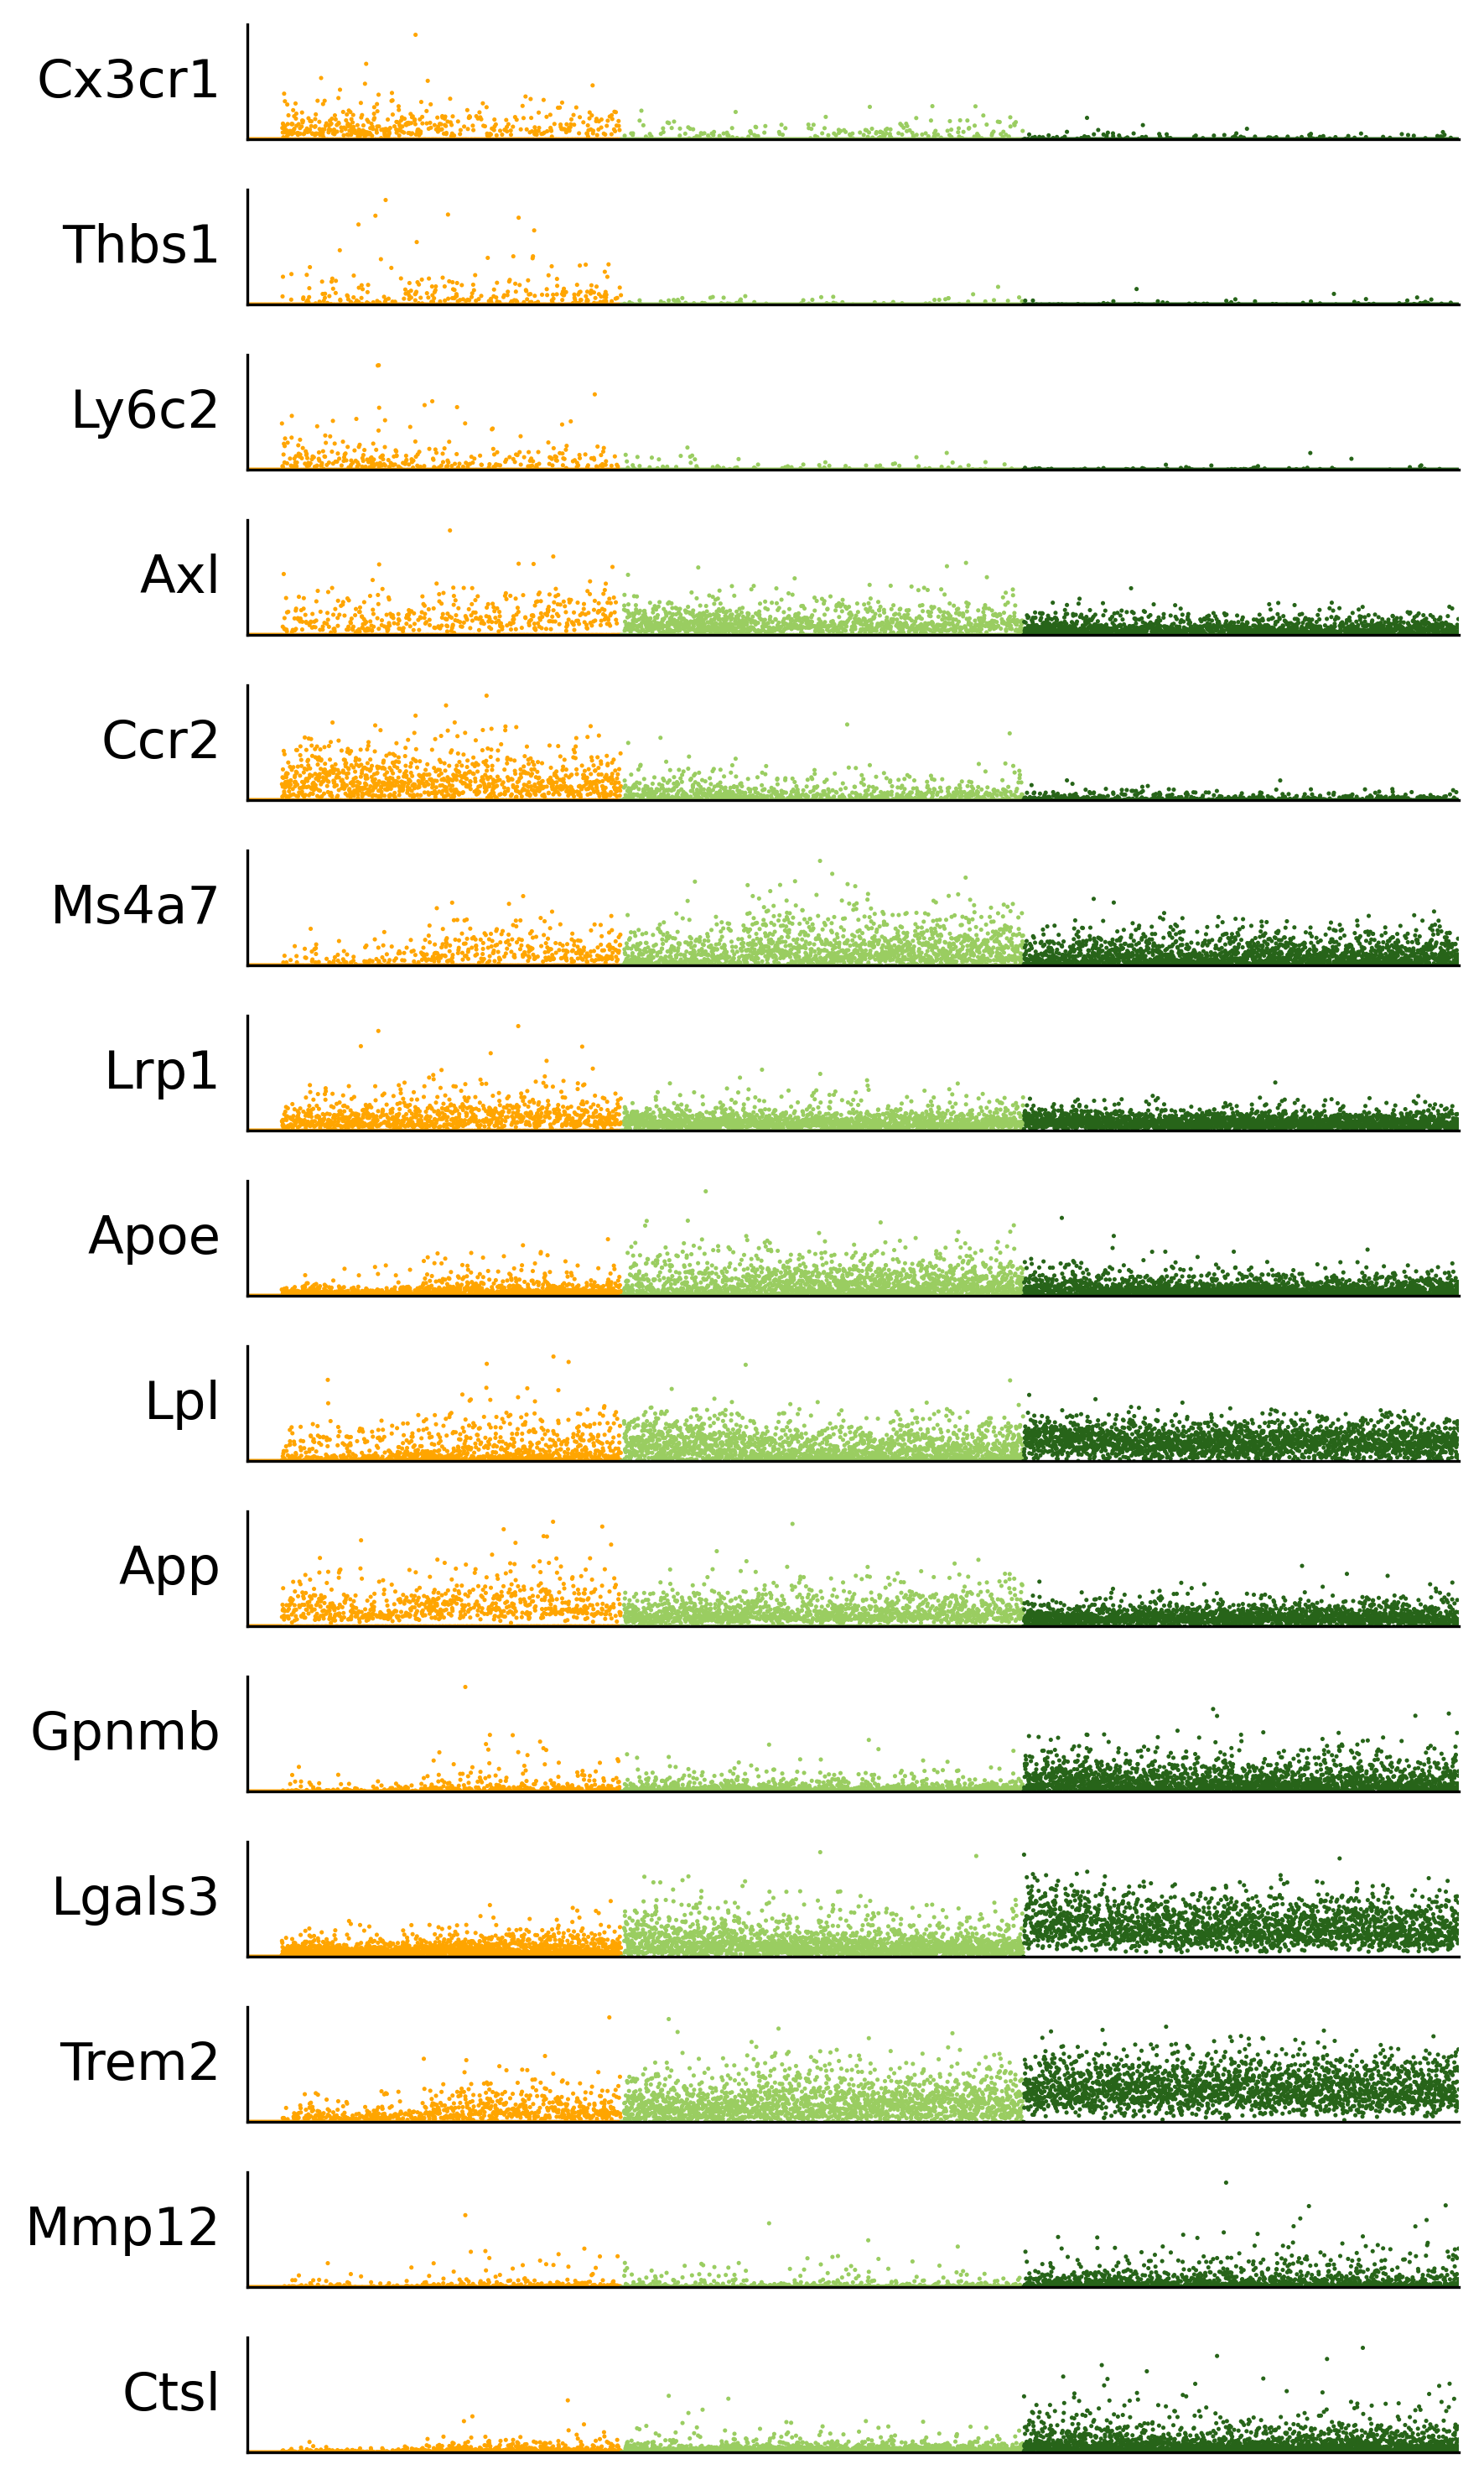

In [38]:
# get cell ids
cid1 = ref[ref['cellType'] == 'Monocytes']['id'].to_list()
cid2 = ref[ref['cellType'] == 'Mac4']['id'].to_list()
cid3 = ref[ref['cellType'] == 'Mac5']['id'].to_list()
cids = cid1 + cid2 + cid3

# type variables
c1 = ['orange'] * len(cid1)
c2 = ['#9acd61'] * len(cid2)
c3 = ['#276419'] * len(cid3)
colors = c1 + c2 + c3

# print(cid1[0])
# print(cid2[0])
# print(cids.index(cid2[0]))

print(f"{len(cid1)=} {len(cid3)=} {len(cid3)=}")

genes = [
    'cx3cr1',
    'THBS1',
    'Ly6c2',
    'Axl',
    "CCR2",
    "MS4A7",
    "Lrp1",
    "Apoe",
    "Lpl",
    "app",
    "gpnmb",
    'Lgals3',
    'Trem2',
    'MMp12',
    'ctsl',
]

genes = [x.upper() for x in genes]

pdf = rdf[rdf.index.isin(cids)]
pdf = pdf.reindex(cids) # sort the rna by the cell ids
pdf = pdf[genes]
pdf = pdf.fillna(0)
pdf['num'] = np.arange(len(pdf))
pdf['color'] = colors
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 10
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(len(genes), 1)
axs = axs.ravel()

for i, g in enumerate(genes):
    
    # gVec = np.log1p(pdf[g].astype(float).to_numpy())
    gVec = pdf[g].astype(float).to_numpy()
    print(f"{g} {gVec.max()=:.2f} {gVec.mean()=:.2f} {np.median(gVec)=:.2f}")
    gVec = sklearn.preprocessing.minmax_scale(gVec, feature_range=(0, 1))
    
    
#     axs[i].bar(pdf['num'], 
#                gVec, 
#                color=pdf['color'])
    
    axs[i].scatter(pdf['num'], 
           gVec, 
           color=pdf['color'],
           ec='None',
           # alpha=0.8,
           s=1.5)
    
    # axis formatting
    axs[i].set_xticks([])
    axs[i].set_ylabel(f"{g.lower().capitalize()}", 
                      rotation=0,
                      fontsize=15,
                      verticalalignment='center',
                      horizontalalignment='right')
    axs[i].set_xlabel("")
    axs[i].set_xlim([0, pdf['num'].max()])
    axs[i].set_ylim([0, 1.1])
    # axs[i].set_yticks([0, gVec.max()], [0, f"{gVec.max():.1f}"])
    axs[i].set_yticks([])
    

    
sns.despine()
plt.tight_layout()

In [6]:
# break

# Variable genes

In [7]:
t = 0.0001
var = rdf.std(axis=0)
print(f"{var.shape=}")
print(var[np.isfinite(var)].describe())

genes = var[var > t]
print(f"{genes.shape=}")

var.shape=(31053,)
count    31053.000000
mean        51.738074
std        274.753549
min          0.000000
25%          0.000000
50%          2.668113
75%         55.553611
max      14472.471547
dtype: float64
genes.shape=(17732,)


In [8]:
# get differential expression of the markers
deg = []

for mtype in sorted(ref['cellType'].unique()):
    print(f"working {mtype}...")
    cellIds = ref[ref['cellType'] == mtype]['id'].to_list()
    
    mask = rdf.index.isin(cellIds)
    inGroup = rdf[mask]
    outGroup = rdf[~mask]

    """DEG for highly variable genes"""
    for g in genes.index:
        score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                           alternative='two-sided')

        lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

        row = {
            'gene' : g,
            "cellType" : mtype,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : inGroup[g].mean(),
            'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
            'meanP2' : outGroup[g].mean(),
            'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
        }
        deg.append(row)
    
deg = pd.DataFrame(deg)
deg.head()

working Mac1...
working Mac2...
working Mac3...
working Mac4...
working Mac5...
working Monocytes...


,gene,cellType,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,SOX17,Mac1,-0.013516,0.989216,-0.071223,0.000000,0.000000,0.050607,0.000287
1,MRPL15,Mac1,-4.052209,0.000051,-0.224923,49.261165,0.228537,57.740987,0.335534
2,LYPLA1,Mac1,-1.293016,0.196005,0.059025,32.488953,0.158404,31.146476,0.196900
3,GM37988,Mac1,-0.027032,0.978434,-0.070802,0.000000,0.000000,0.050301,0.000574
4,TCEA1,Mac1,-4.481343,0.000007,-0.428260,48.629542,0.228537,65.781996,0.341992


alpha=0.05 ntests=17732.0 2.892692318900991e-06
mtype='Mac1' mdf.shape[0]=482 (total DEGs) 
mtype='Mac2' mdf.shape[0]=298 (total DEGs) 
mtype='Mac3' mdf.shape[0]=738 (total DEGs) 
mtype='Mac4' mdf.shape[0]=280 (total DEGs) 
mtype='Mac5' mdf.shape[0]=1968 (total DEGs) 
mtype='Monocytes' mdf.shape[0]=279 (total DEGs) 


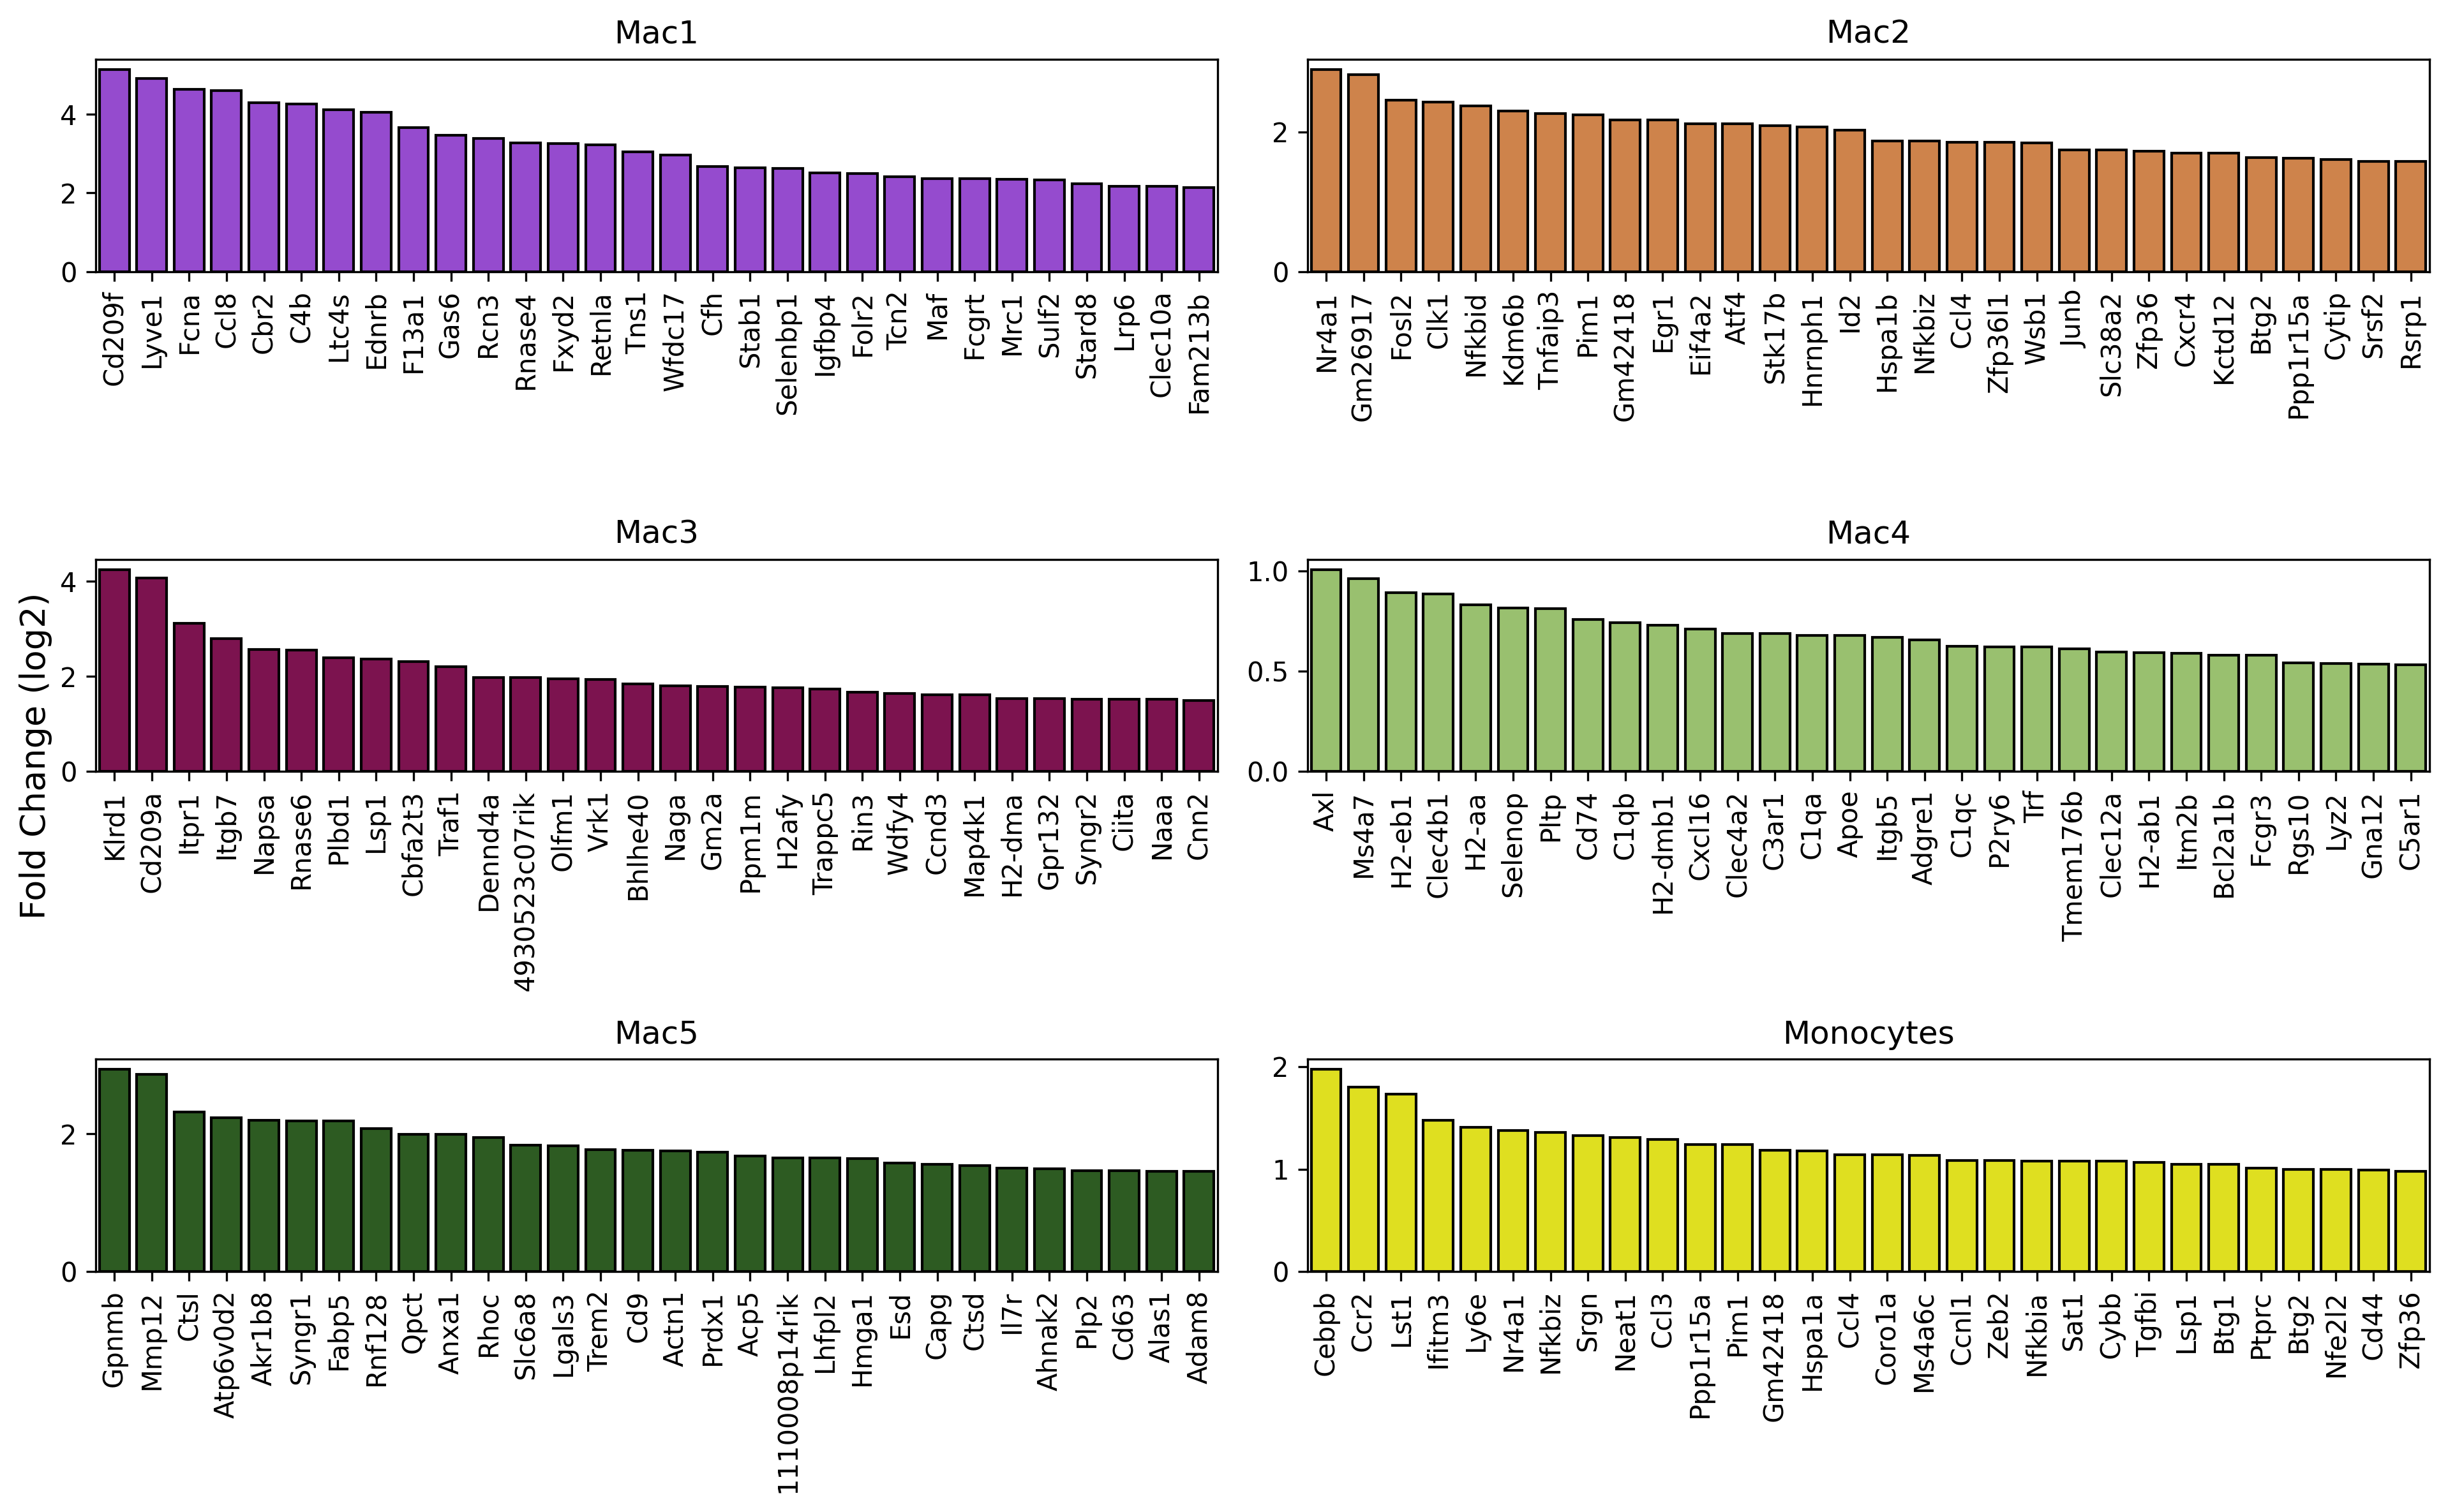

In [9]:
alpha = 0.05
plotN = 15
prop = 0.5
ntests = len(deg) / len(macTypes)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 13, 8
plt.rcParams['figure.facecolor'] = "w"


colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    'yellow',
]


fig, axs = plt.subplots(3, 2)
axs = axs.ravel()


for i, mtype in enumerate(deg['cellType'].unique()):
    
    # get significant DEGs
    mdf = deg[deg['cellType'] == mtype]
    mdf = mdf[mdf['pval'] < alphaHat]
    mdf = mdf[mdf['propP1'] > prop]
    print(f"{mtype=} {mdf.shape[0]=} (total DEGs) ")
    
    mdf = mdf.sort_values(by='log2foldchange', ascending=False)
    mdf = mdf.head(plotN*2)
    # mdf = pd.concat([mdf.head(plotN), mdf.tail(plotN)])
    
    mdf['geneName'] = mdf['gene'].apply(lambda x: str(x).lower().capitalize())
    
    sns.barplot(data=mdf, 
                y='log2foldchange',
                x='geneName',
                edgecolor='k',
                color=colors[i],
                ax=axs[i])
    
    # axs[i].set_title(mtype)
    # axs[i].set_ylabel(mtype, rotation=0, labelpad=10, horizontalalignment='left')
    axs[i].set_title(mtype)
    # axs[i].yaxis.set_label_position("right")
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    
    
fig.supylabel("Fold Change (log2)", fontsize=13)
plt.tight_layout()
    
    

# Pairwise Compairisons

In [15]:
# gets genes expressed in 10% of the population
t = 0.1
nExp = rdf.astype(bool).sum(axis=0)
print(f"{nExp.shape=}")
nExp = nExp / rdf.shape[0]

genes = nExp[nExp > t]
print(f"{genes.shape=}")

nExp.shape=(31053,)
genes.shape=(6394,)


In [16]:
genes.head()

Unnamed: 0
MRPL15     0.324182
LYPLA1     0.192816
TCEA1      0.329955
ATP6V1H    0.409365
RB1CC1     0.273380
dtype: float64

In [23]:
macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]


deg = []

for i_ct, j_ct in itertools.combinations(macTypes, 2):
    print(i_ct, j_ct)
    
    i_cids = ref[ref['cellType'] == i_ct]['id'].to_list()
    j_cids = ref[ref['cellType'] == j_ct]['id'].to_list()
    
    inGroup = rdf[rdf.index.isin(i_cids)]
    outGroup = rdf[rdf.index.isin(j_cids)]

    for g in genes.index:
            score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                               alternative='two-sided')

            lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

            row = {
                'gene' : g,
                "i_ct" : i_ct,
                "j_ct" : j_ct,
                'score' : score,
                'pval' : pval,
                'log2foldchange' : lfc,
                'meanP1' : inGroup[g].mean(),
                'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
                'meanP2' : outGroup[g].mean(),
                'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
            }
            deg.append(row)

deg = pd.DataFrame(deg)
deg.head()

Mac1 Mac2
Mac1 Mac3
Mac1 Mac4
Mac1 Mac5
Mac1 Monocytes
Mac2 Mac3
Mac2 Mac4
Mac2 Mac5
Mac2 Monocytes
Mac3 Mac4
Mac3 Mac5
Mac3 Monocytes
Mac4 Mac5
Mac4 Monocytes
Mac5 Monocytes


,gene,i_ct,j_ct,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,MRPL15,Mac1,Mac2,3.245050,0.001174,0.429896,49.261165,0.228537,36.309639,0.113122
1,LYPLA1,Mac1,Mac2,1.602146,0.109123,-0.049341,32.488953,0.158404,33.654108,0.099548
2,TCEA1,Mac1,Mac2,-0.928891,0.352945,-0.960387,48.629542,0.228537,95.570721,0.242081
3,ATP6V1H,Mac1,Mac2,-1.741621,0.081575,-0.889217,75.072682,0.287787,139.899547,0.316742
4,RB1CC1,Mac1,Mac2,2.648968,0.008074,0.220463,75.879000,0.293833,64.984462,0.194570


In [33]:
alpha = 0.01
ntests = len(genes)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

sig = deg[deg['log2foldchange'].abs() > 1]
sig = sig[sig['pval'] < alphaHat]
print(sig.shape)

sig['up'] = np.where(sig['log2foldchange'] > 0, 1, 0)
sig['down'] = np.where(sig['log2foldchange'] <= 0, 1, 0)


gx = sig.groupby(['i_ct', 'j_ct']).agg(
 up = ('up', 'sum'),
 down = ('down', 'sum'),
).reset_index(drop=False)

print(gx.to_latex(index=False))

alpha=0.01 ntests=6394 1.5718373403972308e-06
(8278, 10)
\begin{tabular}{llrr}
\toprule
 i\_ct &       j\_ct &   up &  down \\
\midrule
 Mac1 &       Mac2 &  374 &   141 \\
 Mac1 &       Mac3 &  375 &   339 \\
 Mac1 &       Mac4 &  184 &   141 \\
 Mac1 &       Mac5 &  217 &   352 \\
 Mac1 &  Monocytes &  394 &   119 \\
 Mac2 &       Mac3 &   89 &   234 \\
 Mac2 &       Mac4 &  170 &   413 \\
 Mac2 &       Mac5 &  208 &   932 \\
 Mac2 &  Monocytes &  136 &    68 \\
 Mac3 &       Mac4 &  306 &   356 \\
 Mac3 &       Mac5 &  485 &   822 \\
 Mac3 &  Monocytes &  145 &    59 \\
 Mac4 &       Mac5 &   46 &    52 \\
 Mac4 &  Monocytes &  210 &    77 \\
 Mac5 &  Monocytes &  546 &   288 \\
\bottomrule
\end{tabular}



In [39]:
sig.head()

,gene,i_ct,j_ct,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2,up,down
20,LY96,Mac1,Mac2,7.246637,4.272463e-13,1.728182,102.507043,0.367594,30.241752,0.126697,1,0
27,PTP4A1,Mac1,Mac2,-6.823150,8.906577e-12,-1.876227,81.683019,0.305925,302.540774,0.457014,0,1
40,COX5B,Mac1,Mac2,12.316188,7.411537e-35,1.195567,343.330945,0.744861,149.339992,0.366516,1,0
61,NABP1,Mac1,Mac2,-6.432863,1.252228e-10,-2.597960,29.321432,0.126965,182.575015,0.323529,0,1
63,GLS,Mac1,Mac2,-6.076982,1.224655e-09,-1.655808,84.515997,0.303507,268.460529,0.443439,0,1


In [40]:
sig.to_csv("~/temp/pairwiseDEG.csv", index=False)